In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-cushing-ok-wti-oil-prices/RWTCd CUSHING OK WTI SPOT PRICES FOB Daily.xls
/kaggle/input/time-series-cushing-ok-wti-oil-prices/RWTCd CUSHING OK WTI SPOT PRICES FOB annual.xls
/kaggle/input/time-series-cushing-ok-wti-oil-prices/RWTCd CUSHING OK WTI SPOT PRICES FOB monthly.xls
/kaggle/input/time-series-cushing-ok-wti-oil-prices/RWTCd CUSHING OK WTI SPOT PRICES FOB weekly.xls


In [2]:
df = pd.read_excel('/kaggle/input/time-series-cushing-ok-wti-oil-prices/RWTCd CUSHING OK WTI SPOT PRICES FOB Daily.xls', sheet_name='Data 1').drop([0,1],axis=0)
df.head()

,Back to Contents,"Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
2,1986-01-02 00:00:00,25.56
3,1986-01-03 00:00:00,26
4,1986-01-06 00:00:00,26.53
5,1986-01-07 00:00:00,25.85
6,1986-01-08 00:00:00,25.87


In [3]:
wti_series = pd.Series(df['Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'])
wti_series

2       25.56
3          26
4       26.53
5       25.85
6       25.87
        ...  
8748    38.29
8749    40.17
8750    40.99
8751    41.09
8752    39.26
Name: Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel), Length: 8751, dtype: object

In [4]:
wti_series = wti_series.reset_index().drop(['index'],axis=1)

In [5]:
wti_series = wti_series.rename(columns = {'Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'wti_spot_price'})

In [6]:
wti_series = pd.Series(wti_series['wti_spot_price'])
wti_series

0       25.56
1          26
2       26.53
3       25.85
4       25.87
        ...  
8746    38.29
8747    40.17
8748    40.99
8749    41.09
8750    39.26
Name: wti_spot_price, Length: 8751, dtype: object

In [7]:
x_train = wti_series[:int(17*len(wti_series)/20)]
x_test = wti_series[int(17*len(wti_series)/20):]

In [8]:
import tensorflow as tf

2025-05-13 13:03:35.453227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747141415.649320      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747141415.707725      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
def windowed_ds(series,window_size,shuffle_buffer_size,batch_size):
    series = pd.Series(series).astype(np.float32).values
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda window: (window[:-1],window[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [10]:
window_size = 20
shuffle_buffer_size = 10000
batch_size = 16

In [11]:
x_tr = windowed_ds(x_train,window_size,shuffle_buffer_size,batch_size)
x_ts = windowed_ds(x_test,window_size,shuffle_buffer_size,batch_size)

2025-05-13 13:03:48.700542: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 64, strides=1,kernel_size=7,padding ='causal',activation = 'relu', input_shape=[None,1]),
                                   tf.keras.layers.LSTM(64,return_sequences=True),
                                   tf.keras.layers.LSTM(64),
                                    tf.keras.layers.Dense(30, activation ='relu'),
                                    tf.keras.layers.Dense(10, activation = 'relu'),
                                   tf.keras.layers.Dense(1, activation = 'relu'),
                                   tf.keras.layers.Lambda(lambda x:x*400)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)

In [14]:
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber, metrics = ['mae'])

In [15]:
history = model.fit(x_tr, callbacks = [lr_scheduler], epochs = 50)

Epoch 1/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 40.5723 - mae: 41.0723 - learning_rate: 1.0000e-08
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 31.5936 - mae: 32.0934 - learning_rate: 1.1220e-08
Epoch 3/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 7.3331 - mae: 7.7915 - learning_rate: 1.2589e-08
Epoch 4/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.8738 - mae: 5.3079 - learning_rate: 1.4125e-08
Epoch 5/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 3.6089 - mae: 4.0172 - learning_rate: 1.5849e-08
Epoch 6/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 2.6703 - mae: 3.0601 - learning_rate: 1.7783e-08
Epoch 7/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 2.1507 - mae: 2.5389 - learning_rate: 1.9953e-08
Epoch 8/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.7996 - mae: 2.1858 - learning_rate: 2.2387e-08
Epoch 9/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.5612 - mae: 1.9366 - learning_rate: 2.5119e-08
Epoch 10/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.5163 - mae: 1.8921 - learning_rate: 2.8184e-08
Epoch 11/50
464/46

In [16]:
import matplotlib.pyplot as plt

(1e-08, 0.001, 0.5, 2.0)

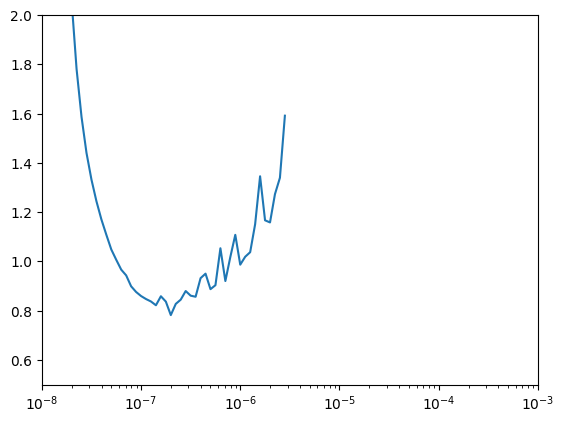

In [17]:
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0.5, 2])

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 2*1e-7, momentum = 0.9)
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber, metrics = ['mae'])

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [20]:
model.fit(x_tr,validation_data = x_ts, epochs = 50, callbacks = [es])

Epoch 1/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.7587 - mae: 1.1178 - val_loss: 0.7049 - val_mae: 1.0955
Epoch 2/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5704 - mae: 0.9074 - val_loss: 0.7062 - val_mae: 1.0968
Epoch 3/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5706 - mae: 0.9095 - val_loss: 0.7219 - val_mae: 1.1177
Epoch 4/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5608 - mae: 0.8890 - val_loss: 0.7040 - val_mae: 1.0982
Epoch 5/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5404 - mae: 0.8782 - val_loss: 0.6964 - val_mae: 1.0892
Epoch 6/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5168 - mae: 0.8467 - val_loss: 0.8090 - val_mae: 1.2110
Epoch 7/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5281 - mae: 0.8620 - val_loss: 0.7412 - val_mae: 1.1341
Epoch 8/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5253 - mae: 0.8549 - val_loss: 0.6904 - val_mae: 1.0819
Epoch 9/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms

In [21]:
forecast = []
actual_val = []
x_ts = tf.data.Dataset.from_tensor_slices(pd.Series(x_test).astype(np.float32).values).window(window_size+1,shift=1,drop_remainder=True).flat_map(lambda e:e.batch(window_size+1)).map(lambda f: (f[:-1],f[-1]))
for X,y in x_ts:
    forecast.append(model.predict(X[np.newaxis],verbose=0))
    actual_val.append(y)

In [22]:
results = np.array(forecast)[:,0,0]
actual_val = np.array(actual_val)[:]
abs(results-actual_val).mean()

1.0818534

In [23]:
wti_series.mean()

44.02998971546095

In [24]:
1.085/44.0299 

0.02464234531534253